## (&#x1F4D7;) Cookbook: Parallelized *STRUCTURE* on unlinked SNPs


### A note on Jupyter/IPython
This is a Jupyter notebook, a reproducible and executable document. This notebook includes mostly Python code, but also a few cells that run bash scripts. Execute each cell in order to follow along. We make use a the ipyparallel library to distribute many replicate *STRUCTURE* jobs among processers to run in parallel. 

### Required software
This notebook requires that you have ipyrad installed, as well as two command line programs, STRUCTURE and CLUMPP. Directions below can be used to install these locally into your conda directory. Installing into the conda dir is convenient because if you are working on an HPC cluster you don't need administrator privileges, and because the binaries in the conda dir should be accessible in your $PATH, meaning you can call the programs by simply typing their name into a terminal. 

### Install *STRUCTURE* binary into conda dir
You can follow the simple instructions here to install the command-line *STRUCTURE* binary into your conda directory so that you can call *STRUCTURE* by simply typing **stucture** into the command line. These instructions 
https://gist.github.com/dereneaton/b4ed0e37767a2c9cf67bc3e45b95c711


### Install CLUMPP binary into conda dir

You can follow the simple instructions here to install the command-line *CLUMPP* binary into your conda directory so that you can call *CLUMPP* by simply typing **clumpp** into the command line. 
https://gist.github.com/dereneaton/6e03d1edf31a36d080fe27f6eec8f686


### Import Python libraries

In [5]:
## these are all available if ipyrad is installed.
import ipyparallel as ipp     ## parallel processing
import ipyrad as ip           ## ipyrad
import numpy as np            ## numerical processing
import pandas as pd           ## data frames
import subprocess             ## for making shell calls
import glob                   ## file/string handling
import os                     ## file handling

## install with `pip install toyplot`
import toyplot                ## plotting library

### Parallel cluster setup
Start an ipcluster instance in a separate terminal, like below. An easy way to do this if your jupyter-notebook is running on an HPC cluster is to go to your Jupyter dashboard, and click [new] and then [terminal], and run `ipcluster start` in that terminal, which will be started on one of the compute nodes. See our [ipyparallel tutorial] for details. 

In [6]:
##
## ipcluster start --n=40
##

In [7]:
## get parallel client
ipyclient = ipp.Client(cluster_id="pedic")

## load-balancer will distribute jobs across the cluster
lbview = ipyclient.load_balanced_view()

## import necessary packages onto remote engines (px magic)
%px import subprocess, os

## print cluster info
print ip.cluster_info(ipyclient)

  host compute node: [20 cores] on tinus


### Make a directory for this analysis

In [8]:
## full path to your structure output directory
STRUCTDIR = "/home/deren/Documents/ipyrad/tests/analysis_structure"

## create the dir
if not os.path.exists(STRUCTDIR):
    os.makedirs(STRUCTDIR)

### Check that you have *STRUCTURE* installed. 
You must be able to call structure from a terminal by typing __structure__. If not, follow the installation instructions in the structure docs to install the command-line version of the software. Below you can see that when I type structure a splash screen is printed and an error is listed that it can't find the params file. That is ok. We will create a params file below. 

In [9]:
! structure



----------------------------------------------------
STRUCTURE by Pritchard, Stephens and Donnelly (2000)
     and Falush, Stephens and Pritchard (2003)
       Code by Pritchard, Falush and Hubisz
             Version 2.3.4 (Jul 2012)
----------------------------------------------------


Can't open the file "mainparams".

Exiting the program due to error(s) listed above.



### Create mainparams and extraparams files for STRUCTURE
structure has two required input files that list a number of parameter settings. The format below is compatible with the ipyrad .str or .ustr files, which STRUCTURE recognizes by having 6 blank columns before the data starts. You may wish to modify these settings, particularly BURNIN and NUMREPS. We don't both with entering several additional parameters here that can instead be entered at the command-line, such as K. 

#### mainparams

In [10]:
## These are almost all default values.
mainparams = """

#define BURNIN           25000     //
#define NUMREPS         250000     //

#define PLOIDY               2     //
#define MISSING             -9     //
#define ONEROWPERIND         0     //     

#define LABEL                1     //
#define POPDATA              0     //
#define POPFLAG              0     //
#define LOCDATA              0     //
#define PHENOTYPE            0     //
#define EXTRACOLS            0     //

#define RANDOMIZE            0     //
#define LOCISPOP             0     //
#define USEPOPINFO           0     //

#define MARKERNAMES          0     //
#define RECESSIVEALLELES     0     //
#define MAPDISTANCES         0     //
#define PHASED               0     //
#define PHASEINFO            0     //
#define MARKOVPHASE          0     //
#define NOTAMBIGUOUS      -999     //
"""

## write to file
mainfile = os.path.join(STRUCTDIR, "mainparams.txt")
with open(mainfile, 'w') as out:
    out.write(mainparams)

#### extraparams

In [11]:
## These are simply the default values 
extraparams = """

#define NOADMIX                   0    //
#define LINKAGE                   0    //
#define USEPOPINFO                0    //
#define LOCPRIOR                  0    //
#define FREQSCORR                 1    //
#define ONEFST                    0    //
#define INFERALPHA                1    // 
#define POPALPHAS                 0    // 
#define ALPHA                   1.0    // 

#define INFERLAMBDA               0    //
#define POPSPECIFICLAMBDA         0    //
#define LAMBDA                  1.0    // 

#define FPRIORMEAN             0.01    //
#define FPRIORSD               0.05    // 
#define UNIFPRIORALPHA            1    // 
#define ALPHAMAX               10.0    // 
#define ALPHAPRIORA             1.0    // 
#define ALPHAPRIORB             2.0    //
#define LOG10RMIN              -4.0    //
#define LOG10RMAX               1.0    //
#define LOG10RPROPSD            0.1    //
#define LOG10RSTART            -2.0    //

#define GENSBACK                  2    //
#define MIGRPRIOR              0.01    //
#define PFROMPOPFLAGONLY          0    //

#define LOCISPOP                  0    //
#define LOCPRIORINIT            1.0    //
#define MAXLOCPRIOR            20.0    //

#define PRINTNET                  1    // 
#define PRINTLAMBDA               1    //
#define PRINTQSUM                 1    //
#define SITEBYSITE                0    // 
#define PRINTQHAT                 0    // 
#define UPDATEFREQ              100    // 
#define PRINTLIKES                0    // 
#define INTERMEDSAVE              0    //
#define ECHODATA                  1    // 
#define ANCESTDIST                0    // 
#define NUMBOXES               1000    // 
#define ANCESTPINT             0.90    // 

#define COMPUTEPROB               1    //
#define ADMBURNIN               500    // 
#define ALPHAPROPSD           0.025    // 
#define STARTATPOPINFO            0    //
#define RANDOMIZE                 0    //
#define SEED                   2245    //
#define METROFREQ                10    // 
#define REPORTHITRATE             0    //  

"""
## write to file
extrafile = os.path.join(STRUCTDIR, "extraparams.txt")
with open(extrafile, 'w') as out:
    out.write(extraparams)

### Creat a function to call structure
This function is just a Python wrapper to call structure and pass it a list of arguments. 

In [12]:
def call_structure(K, rep, rand, Ninds, Nloci, STRUCTDIR, ustrfile):

    ## create call string
    outname = os.path.join(STRUCTDIR, "K-{}-rep-{}".format(K, rep))
    
    cmd = ["structure", 
           "-m", os.path.join(STRUCTDIR, "mainparams.txt"),
           "-e", os.path.join(STRUCTDIR, "extraparams.txt"),
           "-K", str(K),
           "-N", str(Ninds), 
           "-L", str(Nloci),
           "-D", str(rand), 
           "-i", ustrfile, 
           "-o", outname]

    ## call the shell function
    proc = subprocess.Popen(cmd,
                            stdout=subprocess.PIPE, 
                            stderr=subprocess.STDOUT)
    comm = proc.communicate()
    return comm

### Organize input files
Enter your .str or .ustr data file here, and the range of K values you wish to test. 

In [13]:
## unlinked SNPs file
ustrfile = "/home/deren/Documents/ipyrad/tests/analysis-ipyrad/pedicularis_outfiles/pedicularis.ustr"

## a list of K=x hypotheses to test
testKs = [3, 4, 5, 6]

### Parse N individuals and N SNPs from input file 

In [14]:
with open(ustrfile) as ifile:
    lines = ifile.readlines()
    Ninds = len(lines)//2
    Nloci = len(lines[0].strip().split()[1:])
    print Ninds, "samples in data set"
    print Nloci, 'SNPs in structure data set'

13 samples in data set
38078 SNPs in structure data set


### Parallel processing 
Collect arguments to structure into a list so we can pass them all to run in parallel on many processors. Each list contains a K-value, a replicate number, and a random-seed number, as well as the input file name. 

In [16]:
args = []

## for each value of K
for K in testKs:

    ## do ten replicates
    for rep in range(5):
    
        ## get a random seed
        rand = np.random.randint(0, int(1e9))
        
        ## add a few additional args
        args.append([K, rep, rand, Ninds, Nloci, STRUCTDIR, ustrfile])
        
## all jobs
print "args contains {} job lists".format(len(args))

args contains 20 job lists


In [17]:
## submit jobs to the cluster: `call_structure(*args)`.
asyncs = {}
for idx in xrange(len(args)):
    asyncs[idx] = lbview.apply(call_structure, *args[idx])

## print that jobs were submitted
print "{} jobs submitted".format(len(args))

20 jobs submitted


### Track progress and wait
If you get an error very quickly the most likely problem is that you did not enter full path names in the file or directory paths above. Check that first. Otherwise, watch it run. STRUCTURE is kind of slow, but if your data set is not too huge, then it should run in a a few hours at most. I suspect STRUCTURE may be more accurate than faster methods like ADMIXTURE or fast-structure when there is a lot of missing data, like in RAD-seq, but I haven't tested this explicitly. It may be necessary to run this for a long time to reach convergence. We set the number of MCMC steps fairly high for this demo, at 100K. See our other notebooks for instructions on using [fast-structure] (not yet available). 

In [26]:
## this will print progress until jobs are done
print sum([i.ready() for i in asyncs.values()]), "/", len(asyncs), "finished"

5 / 20 finished


#### If jobs fail, check for errors (If no errors, then nothing should print from this cell)

In [87]:
## To examine details of each individual job you could check their
## 'async' result objects. Here we grab the joint stdout/stderr  
stdout = asyncs[0].result()[0]

## If an exception arose, then prints here
error = asyncs[0].exception()
if error:
    print error
    print stdout

### Summarize replicates with CLUMPP
Again, this part of the code assumes that you've downloaded and installed the software CLUMPP, which is used to summarize results across replicate runs of STRUCTURE. We ran ten replicates per K-value hypothesis. If you type CLUMPP into a terminal you should see the following message. Again, an error that there is no params file. Don't worry, we'll make one below. 

### Create a CLUMPP params file

In [27]:
cparams = """
DATATYPE                 0  #
INDFILE                  0  #
POPFILE                  0  #
OUTFILE                  0  #
MISCFILE                 0  #
K                        3  #
C                        3  #
R                       10  #
M                        3  #
W                        1  #
S                        2  # 
GREEDY_OPTION            2  #
REPEATS               1000  #
PERMUTATIONFILE          0  #
PRINT_PERMUTED_DATA      0  #
PERMUTED_DATAFILE        0  #
PRINT_EVERY_PERM         0  #
EVERY_PERMFILE           0  #
PRINT_RANDOM_INPUTORDER  0  # 
RANDOM_INPUTORDERFILE    0  #
OVERRIDE_WARNINGS        0  #
ORDER_BY_RUN             1  #
"""

## write to file
clumpfile = os.path.join(STRUCTDIR, "clumpparams.txt")
with open(clumpfile, 'w') as out:
    out.write(cparams)

### Create a function wrapper to call CLUMPP

In [28]:
def build_clumpp(K, STRUCTDIR): 
    "combine replicates into single indfile"
   
    ## grab all the _f result files
    reps = os.path.join(STRUCTDIR, "K-{}-rep-*".format(K))
    repfiles = glob.glob(reps)
    
    ## make an output handle
    outf = os.path.join(STRUCTDIR, "K-{}.indfile".format(K))
    
    ## combine replicates and write to indfile
    with open(outf, 'w') as outfile:
        for rep in repfiles:
            i = 1
            ## strips junk to extract matrix
            for line in open(rep).readlines():
                ## matrix lines have this junk
                if ")   :  " in line:
                    ## split it up on whitespace
                    ll = line.strip().split()
                    outstr = "{}{}{}".format(
                        " ".join([ll[0], ll[0], ll[2], ll[0].split('.')[0]]),
                        " :  ",
                        " ".join(ll[4:])
                    ) 
                    outfile.write(outstr+"\n")
                    i += 1
        outfile.write("\n")    
    return len(repfiles), i-1

In [29]:
def call_clumpp(K, STRUCTDIR, Ninds, Nreps):
    
    ## create CLUMPP args string
    cmd = ["CLUMPP", os.path.join(STRUCTDIR, "clumpparams.txt"), 
           "-i", os.path.join(STRUCTDIR, "K-{}.indfile".format(K)),
           "-o", os.path.join(STRUCTDIR, "K-{}.outfile".format(K)),
           "-j", os.path.join(STRUCTDIR, "K-{}.miscfile".format(K)),
           "-r", str(Nreps), 
           "-c", str(Ninds), 
           "-k", str(K)]
    ## call clumpp
    proc = subprocess.Popen(cmd, 
                            stderr=subprocess.STDOUT, 
                            stdout=subprocess.PIPE)
    comm = proc.communicate()
    return comm

### Run CLUMPP for each K-value

In [157]:
for K in testKs:
    Nreps, Ninds = build_clumpp(K, STRUCTDIR)
    comm = call_clumpp(K, STRUCTDIR, Ninds, Nreps)

### Parse sample name order from the .ustr data file
Here we parse the names from the .ustr file and save it in a list call `inputnames`. 

In [158]:
## parse names
with open(ustrfile) as ifile:
    inputnames = [i.split()[0] for i in ifile.readlines()][::2]

## print names list
for idx, name in enumerate(inputnames):
    print idx, name

0 29154_superba
1 30556_thamno
2 30686_cyathophylla
3 32082_przewalskii
4 33413_thamno
5 33588_przewalskii
6 35236_rex
7 35855_rex
8 38362_rex
9 39618_rex
10 40578_rex
11 41478_cyathophylloides
12 41954_cyathophylloides


### Parse structure results table from the `structure` outfile

In [160]:
## parse clumpp K=4 outfile
ofile = os.path.join(STRUCTDIR, "K-5.outfile")
table = pd.read_csv(ofile,
                    delim_whitespace=True, 
                    header=None).ix[:, 5:]

## apply names to cols and rows
table.columns = range(table.shape[1])
table.index = inputnames
print table

                             0       1       2       3    4
29154_superba           0.0094  0.9870  0.0000  0.0036  0.0
30556_thamno            0.9686  0.0000  0.0314  0.0000  0.0
30686_cyathophylla      0.0000  0.9966  0.0000  0.0034  0.0
32082_przewalskii       0.0000  0.0000  0.0000  0.0000  1.0
33413_thamno            0.9668  0.0050  0.0282  0.0000  0.0
33588_przewalskii       0.0000  0.0000  0.0000  0.0000  1.0
35236_rex               0.8644  0.0044  0.1312  0.0000  0.0
35855_rex               0.9610  0.0030  0.0360  0.0000  0.0
38362_rex               0.0000  0.0000  1.0000  0.0000  0.0
39618_rex               0.0142  0.0000  0.9858  0.0000  0.0
40578_rex               0.9646  0.0000  0.0354  0.0000  0.0
41478_cyathophylloides  0.0000  0.0000  0.0000  1.0000  0.0
41954_cyathophylloides  0.0000  0.0000  0.0000  1.0000  0.0


### Sort the order how you like it
This can be useful if, for example, you want to order the names to be in the same order as tips on your phylogeny. 

In [161]:
## custom sorting order
myorder = [
    "32082_przewalskii", "33588_przewalskii",
    "41478_cyathophylloides", "41954_cyathophylloides", 
    "30686_cyathophylla", "29154_superba",
    "33413_thamno", "30556_thamno", 
    "35236_rex", 
    "40578_rex", "35855_rex",
    "39618_rex", "38362_rex",
]

print "custom ordering"
print table.ix[myorder]

print "\nor, automatically ordered by group membership"
print table.sort_values(table.columns.tolist())

custom ordering
                             0       1       2       3    4
32082_przewalskii       0.0000  0.0000  0.0000  0.0000  1.0
33588_przewalskii       0.0000  0.0000  0.0000  0.0000  1.0
41478_cyathophylloides  0.0000  0.0000  0.0000  1.0000  0.0
41954_cyathophylloides  0.0000  0.0000  0.0000  1.0000  0.0
30686_cyathophylla      0.0000  0.9966  0.0000  0.0034  0.0
29154_superba           0.0094  0.9870  0.0000  0.0036  0.0
33413_thamno            0.9668  0.0050  0.0282  0.0000  0.0
30556_thamno            0.9686  0.0000  0.0314  0.0000  0.0
35236_rex               0.8644  0.0044  0.1312  0.0000  0.0
40578_rex               0.9646  0.0000  0.0354  0.0000  0.0
35855_rex               0.9610  0.0030  0.0360  0.0000  0.0
39618_rex               0.0142  0.0000  0.9858  0.0000  0.0
38362_rex               0.0000  0.0000  1.0000  0.0000  0.0

or, automatically ordered by group membership
                             0       1       2       3    4
32082_przewalskii       0.0000  0.000

### A toyplot barplot (with interactive hover)
The function automatically parses the table above for you. It can reorder the individuals based on their membership in each group, or based on an input list of order names. It also returns a list with information for making interactive hover boxes, which you can see below by hovering over the plots.  

In [162]:
def prep_table(clumppfile, inputnames, reorder=None):
    ## parse clumpp output file
    table = pd.read_csv(clumppfile,
                    delim_whitespace=True, 
                    header=None).ix[:, 5:]
    table.columns = range(table.shape[1])
    table.index = inputnames

    ## reorder rows
    if isinstance(reorder, int):
        if reorder:
            table = table.sort_values(table.columns.tolist())
    elif isinstance(reorder, list):
        table = table.ix[reorder]
    
    ## for each column
    hover = []
    for row in range(table.shape[0]):
        stack = []
        for col in range(table.shape[1]):
            stack.append("Name: {}, Group: {}, Prop: {}"\
                .format(table.index[row], col, table.ix[row, col]))
        hover.append(stack)
    
    ## returns table and hover list
    return table, np.array(hover)

### K plots 
Hover over the plot to see sample names and info in the hover box. 

In [163]:
for K in testKs:
    ## parse outfile
    ofile = os.path.join(STRUCTDIR, "K-{}.outfile".format(K))
    table, title = prep_table(ofile, inputnames, reorder=myorder)
    
    ## plot bars
    xlabel="K={}".format(K)
    toyplot.bars(table, title=title, 
                 width=400, height=200, 
                 yshow=False, xlabel=xlabel);

Name: 32082_przewalskii, Group: 0, Prop: 0.0 Name: 33588_przewalskii, Group: 0, Prop: 0.0 Name: 41478_cyathophylloides, Group: 0, Prop: 0.0 Name: 41954_cyathophylloides, Group: 0, Prop: 0.0 Name: 30686_cyathophylla, Group: 0, Prop: 0.0588 Name: 29154_superba, Group: 0, Prop: 0.065 Name: 33413_thamno, Group: 0, Prop: 1.0 Name: 30556_thamno, Group: 0, Prop: 1.0 Name: 35236_rex, Group: 0, Prop: 1.0 Name: 40578_rex, Group: 0, Prop: 1.0 Name: 35855_rex, Group: 0, Prop: 1.0 Name: 39618_rex, Group: 0, Prop: 1.0 Name: 38362_rex, Group: 0, Prop: 1.0 Name: 32082_przewalskii, Group: 1, Prop: 0.0 Name: 33588_przewalskii, Group: 1, Prop: 0.0 Name: 41478_cyathophylloides, Group: 1, Prop: 1.0 Name: 41954_cyathophylloides, Group: 1, Prop: 1.0 Name: 30686_cyathophylla, Group: 1, Prop: 0.8976 Name: 29154_superba, Group: 1, Prop: 0.8942 Name: 33413_thamno, Group: 1, Prop: 0.0 Name: 30556_thamno, Group: 1, Prop: 0.0 Name: 35236_rex, Group: 1, Prop: 0.0 Name: 40578_rex, Group: 1, Prop: 0.0 Name: 35855_rex, Group: 1, Prop: 0.0 Name: 39618_rex, Group: 1, Prop: 0.0 Name: 38362_rex, Group: 1, Prop: 0.0 Name: 32082_przewalskii, Group: 2, Prop: 1.0 Name: 33588_przewalskii, Group: 2, Prop: 1.0 Name: 41478_cyathophylloides, Group: 2, Prop: 0.0 Name: 41954_cyathophylloides, Group: 2, Prop: 0.0 Name: 30686_cyathophylla, Group: 2, Prop: 0.0436 Name: 29154_superba, Group: 2, Prop: 0.0408 Name: 33413_thamno, Group: 2, Prop: 0.0 Name: 30556_thamno, Group: 2, Prop: 0.0 Name: 35236_rex, Group: 2, Prop: 0.0 Name: 40578_rex, Group: 2, Prop: 0.0 Name: 35855_rex, Group: 2, Prop: 0.0 Name: 39618_rex, Group: 2, Prop: 0.0 Name: 38362_rex, Group: 2, Prop: 0.0 0 4 8 12 K=3 
 
 
 Save as .csv

Name: 32082_przewalskii, Group: 0, Prop: 0.0 Name: 33588_przewalskii, Group: 0, Prop: 0.0 Name: 41478_cyathophylloides, Group: 0, Prop: 0.0 Name: 41954_cyathophylloides, Group: 0, Prop: 0.0 Name: 30686_cyathophylla, Group: 0, Prop: 0.0004 Name: 29154_superba, Group: 0, Prop: 0.0 Name: 33413_thamno, Group: 0, Prop: 0.009 Name: 30556_thamno, Group: 0, Prop: 0.164 Name: 35236_rex, Group: 0, Prop: 0.2322 Name: 40578_rex, Group: 0, Prop: 0.1592 Name: 35855_rex, Group: 0, Prop: 0.1744 Name: 39618_rex, Group: 0, Prop: 1.0 Name: 38362_rex, Group: 0, Prop: 1.0 Name: 32082_przewalskii, Group: 1, Prop: 1.0 Name: 33588_przewalskii, Group: 1, Prop: 1.0 Name: 41478_cyathophylloides, Group: 1, Prop: 0.0 Name: 41954_cyathophylloides, Group: 1, Prop: 0.0 Name: 30686_cyathophylla, Group: 1, Prop: 0.0 Name: 29154_superba, Group: 1, Prop: 0.0 Name: 33413_thamno, Group: 1, Prop: 0.0 Name: 30556_thamno, Group: 1, Prop: 0.0 Name: 35236_rex, Group: 1, Prop: 0.0 Name: 40578_rex, Group: 1, Prop: 0.0 Name: 35855_rex, Group: 1, Prop: 0.0 Name: 39618_rex, Group: 1, Prop: 0.0 Name: 38362_rex, Group: 1, Prop: 0.0 Name: 32082_przewalskii, Group: 2, Prop: 0.0 Name: 33588_przewalskii, Group: 2, Prop: 0.0 Name: 41478_cyathophylloides, Group: 2, Prop: 0.0 Name: 41954_cyathophylloides, Group: 2, Prop: 0.0 Name: 30686_cyathophylla, Group: 2, Prop: 0.6256 Name: 29154_superba, Group: 2, Prop: 0.6404 Name: 33413_thamno, Group: 2, Prop: 0.991 Name: 30556_thamno, Group: 2, Prop: 0.836 Name: 35236_rex, Group: 2, Prop: 0.7678 Name: 40578_rex, Group: 2, Prop: 0.8408 Name: 35855_rex, Group: 2, Prop: 0.8256 Name: 39618_rex, Group: 2, Prop: 0.0 Name: 38362_rex, Group: 2, Prop: 0.0 Name: 32082_przewalskii, Group: 3, Prop: 0.0 Name: 33588_przewalskii, Group: 3, Prop: 0.0 Name: 41478_cyathophylloides, Group: 3, Prop: 1.0 Name: 41954_cyathophylloides, Group: 3, Prop: 1.0 Name: 30686_cyathophylla, Group: 3, Prop: 0.374 Name: 29154_superba, Group: 3, Prop: 0.3596 Name: 33413_thamno, Group: 3, Prop: 0.0 Name: 30556_thamno, Group: 3, Prop: 0.0 Name: 35236_rex, Group: 3, Prop: 0.0 Name: 40578_rex, Group: 3, Prop: 0.0 Name: 35855_rex, Group: 3, Prop: 0.0 Name: 39618_rex, Group: 3, Prop: 0.0 Name: 38362_rex, Group: 3, Prop: 0.0 0 4 8 12 K=4 
 
 
 Save as .csv

Name: 32082_przewalskii, Group: 0, Prop: 0.0 Name: 33588_przewalskii, Group: 0, Prop: 0.0 Name: 41478_cyathophylloides, Group: 0, Prop: 0.0 Name: 41954_cyathophylloides, Group: 0, Prop: 0.0 Name: 30686_cyathophylla, Group: 0, Prop: 0.0 Name: 29154_superba, Group: 0, Prop: 0.0094 Name: 33413_thamno, Group: 0, Prop: 0.9668 Name: 30556_thamno, Group: 0, Prop: 0.9686 Name: 35236_rex, Group: 0, Prop: 0.8644 Name: 40578_rex, Group: 0, Prop: 0.9646 Name: 35855_rex, Group: 0, Prop: 0.961 Name: 39618_rex, Group: 0, Prop: 0.0142 Name: 38362_rex, Group: 0, Prop: 0.0 Name: 32082_przewalskii, Group: 1, Prop: 0.0 Name: 33588_przewalskii, Group: 1, Prop: 0.0 Name: 41478_cyathophylloides, Group: 1, Prop: 0.0 Name: 41954_cyathophylloides, Group: 1, Prop: 0.0 Name: 30686_cyathophylla, Group: 1, Prop: 0.9966 Name: 29154_superba, Group: 1, Prop: 0.987 Name: 33413_thamno, Group: 1, Prop: 0.005 Name: 30556_thamno, Group: 1, Prop: 0.0 Name: 35236_rex, Group: 1, Prop: 0.0044 Name: 40578_rex, Group: 1, Prop: 0.0 Name: 35855_rex, Group: 1, Prop: 0.003 Name: 39618_rex, Group: 1, Prop: 0.0 Name: 38362_rex, Group: 1, Prop: 0.0 Name: 32082_przewalskii, Group: 2, Prop: 0.0 Name: 33588_przewalskii, Group: 2, Prop: 0.0 Name: 41478_cyathophylloides, Group: 2, Prop: 0.0 Name: 41954_cyathophylloides, Group: 2, Prop: 0.0 Name: 30686_cyathophylla, Group: 2, Prop: 0.0 Name: 29154_superba, Group: 2, Prop: 0.0 Name: 33413_thamno, Group: 2, Prop: 0.0282 Name: 30556_thamno, Group: 2, Prop: 0.0314 Name: 35236_rex, Group: 2, Prop: 0.1312 Name: 40578_rex, Group: 2, Prop: 0.0354 Name: 35855_rex, Group: 2, Prop: 0.036 Name: 39618_rex, Group: 2, Prop: 0.9858 Name: 38362_rex, Group: 2, Prop: 1.0 Name: 32082_przewalskii, Group: 3, Prop: 0.0 Name: 33588_przewalskii, Group: 3, Prop: 0.0 Name: 41478_cyathophylloides, Group: 3, Prop: 1.0 Name: 41954_cyathophylloides, Group: 3, Prop: 1.0 Name: 30686_cyathophylla, Group: 3, Prop: 0.0034 Name: 29154_superba, Group: 3, Prop: 0.0036 Name: 33413_thamno, Group: 3, Prop: 0.0 Name: 30556_thamno, Group: 3, Prop: 0.0 Name: 35236_rex, Group: 3, Prop: 0.0 Name: 40578_rex, Group: 3, Prop: 0.0 Name: 35855_rex, Group: 3, Prop: 0.0 Name: 39618_rex, Group: 3, Prop: 0.0 Name: 38362_rex, Group: 3, Prop: 0.0 Name: 32082_przewalskii, Group: 4, Prop: 1.0 Name: 33588_przewalskii, Group: 4, Prop: 1.0 Name: 41478_cyathophylloides, Group: 4, Prop: 0.0 Name: 41954_cyathophylloides, Group: 4, Prop: 0.0 Name: 30686_cyathophylla, Group: 4, Prop: 0.0 Name: 29154_superba, Group: 4, Prop: 0.0 Name: 33413_thamno, Group: 4, Prop: 0.0 Name: 30556_thamno, Group: 4, Prop: 0.0 Name: 35236_rex, Group: 4, Prop: 0.0 Name: 40578_rex, Group: 4, Prop: 0.0 Name: 35855_rex, Group: 4, Prop: 0.0 Name: 39618_rex, Group: 4, Prop: 0.0 Name: 38362_rex, Group: 4, Prop: 0.0 0 4 8 12 K=5 
 
 
 Save as .csv

Name: 32082_przewalskii, Group: 0, Prop: 0.0 Name: 33588_przewalskii, Group: 0, Prop: 0.0 Name: 41478_cyathophylloides, Group: 0, Prop: 0.0 Name: 41954_cyathophylloides, Group: 0, Prop: 0.0 Name: 30686_cyathophylla, Group: 0, Prop: 1.0 Name: 29154_superba, Group: 0, Prop: 0.9984 Name: 33413_thamno, Group: 0, Prop: 0.0 Name: 30556_thamno, Group: 0, Prop: 0.0 Name: 35236_rex, Group: 0, Prop: 0.0 Name: 40578_rex, Group: 0, Prop: 0.0 Name: 35855_rex, Group: 0, Prop: 0.0 Name: 39618_rex, Group: 0, Prop: 0.0 Name: 38362_rex, Group: 0, Prop: 0.0 Name: 32082_przewalskii, Group: 1, Prop: 0.0 Name: 33588_przewalskii, Group: 1, Prop: 0.0 Name: 41478_cyathophylloides, Group: 1, Prop: 0.0 Name: 41954_cyathophylloides, Group: 1, Prop: 0.0 Name: 30686_cyathophylla, Group: 1, Prop: 0.0 Name: 29154_superba, Group: 1, Prop: 0.0 Name: 33413_thamno, Group: 1, Prop: 0.0212 Name: 30556_thamno, Group: 1, Prop: 0.0262 Name: 35236_rex, Group: 1, Prop: 0.108 Name: 40578_rex, Group: 1, Prop: 0.0276 Name: 35855_rex, Group: 1, Prop: 0.0278 Name: 39618_rex, Group: 1, Prop: 0.987 Name: 38362_rex, Group: 1, Prop: 1.0 Name: 32082_przewalskii, Group: 2, Prop: 0.0 Name: 33588_przewalskii, Group: 2, Prop: 0.0 Name: 41478_cyathophylloides, Group: 2, Prop: 1.0 Name: 41954_cyathophylloides, Group: 2, Prop: 1.0 Name: 30686_cyathophylla, Group: 2, Prop: 0.0 Name: 29154_superba, Group: 2, Prop: 0.0002 Name: 33413_thamno, Group: 2, Prop: 0.0 Name: 30556_thamno, Group: 2, Prop: 0.0 Name: 35236_rex, Group: 2, Prop: 0.0 Name: 40578_rex, Group: 2, Prop: 0.0 Name: 35855_rex, Group: 2, Prop: 0.0 Name: 39618_rex, Group: 2, Prop: 0.0 Name: 38362_rex, Group: 2, Prop: 0.0 Name: 32082_przewalskii, Group: 3, Prop: 0.0 Name: 33588_przewalskii, Group: 3, Prop: 0.0 Name: 41478_cyathophylloides, Group: 3, Prop: 0.0 Name: 41954_cyathophylloides, Group: 3, Prop: 0.0 Name: 30686_cyathophylla, Group: 3, Prop: 0.0 Name: 29154_superba, Group: 3, Prop: 0.0 Name: 33413_thamno, Group: 3, Prop: 0.9026 Name: 30556_thamno, Group: 3, Prop: 0.787 Name: 35236_rex, Group: 3, Prop: 0.288 Name: 40578_rex, Group: 3, Prop: 0.9664 Name: 35855_rex, Group: 3, Prop: 0.9676 Name: 39618_rex, Group: 3, Prop: 0.013 Name: 38362_rex, Group: 3, Prop: 0.0 Name: 32082_przewalskii, Group: 4, Prop: 0.0 Name: 33588_przewalskii, Group: 4, Prop: 0.0 Name: 41478_cyathophylloides, Group: 4, Prop: 0.0 Name: 41954_cyathophylloides, Group: 4, Prop: 0.0 Name: 30686_cyathophylla, Group: 4, Prop: 0.0 Name: 29154_superba, Group: 4, Prop: 0.0014 Name: 33413_thamno, Group: 4, Prop: 0.0762 Name: 30556_thamno, Group: 4, Prop: 0.1868 Name: 35236_rex, Group: 4, Prop: 0.604 Name: 40578_rex, Group: 4, Prop: 0.006 Name: 35855_rex, Group: 4, Prop: 0.0046 Name: 39618_rex, Group: 4, Prop: 0.0 Name: 38362_rex, Group: 4, Prop: 0.0 Name: 32082_przewalskii, Group: 5, Prop: 1.0 Name: 33588_przewalskii, Group: 5, Prop: 1.0 Name: 41478_cyathophylloides, Group: 5, Prop: 0.0 Name: 41954_cyathophylloides, Group: 5, Prop: 0.0 Name: 30686_cyathophylla, Group: 5, Prop: 0.0 Name: 29154_superba, Group: 5, Prop: 0.0 Name: 33413_thamno, Group: 5, Prop: 0.0 Name: 30556_thamno, Group: 5, Prop: 0.0 Name: 35236_rex, Group: 5, Prop: 0.0 Name: 40578_rex, Group: 5, Prop: 0.0 Name: 35855_rex, Group: 5, Prop: 0.0 Name: 39618_rex, Group: 5, Prop: 0.0 Name: 38362_rex, Group: 5, Prop: 0.0 0 4 8 12 K=6 
 
 
 Save as .csv

### Save a plot to file

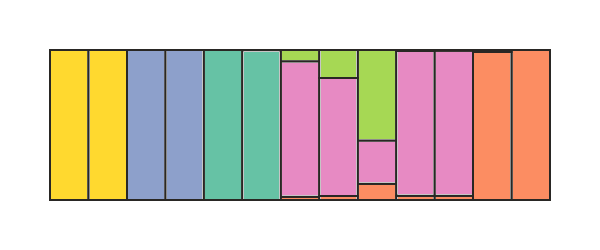

In [164]:
## parse outfile to get table and title
K = 4
ofile = os.path.join(STRUCTDIR, "K-6.outfile".format(K))

## prep
table, title = prep_table(ofile, inputnames, reorder=myorder)

## further styling of plot with css 
style = {"stroke":toyplot.color.near_black, 
         "stroke-width": 2}

## build plot
canvas = toyplot.Canvas(width=600, height=250)
axes = canvas.cartesian()
axes.bars(table, title=title, style=style)
axes.show = False

## options: uncomment to save plots. Only html retains hover.
import toyplot.svg
import toyplot.pdf
import toyplot.html
#toyplot.svg.render(canvas, "struct.svg")
#toyplot.pdf.render(canvas, "struct.pdf")
#toyplot.html.render(canvas, "struct.html")

## show in notebook
canvas

### Calculating the best K 
I like using the site http://taylor0.biology.ucla.edu/structureHarvester/. It's great. Super easy. Zip up all the files in our structure directory, submit them to the site, and you're done. In case you're wondering, for this data set, StructureHarvester likes K=4 best. 

In [165]:
%%bash -s "$STRUCTDIR"

## creates zip dir of all files ending with _f
zip $1/structure-files.zip $1/*_f

updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-0_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-1_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-2_f (deflated 81%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-3_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-4_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-0_f (deflated 80%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-1_f (deflated 80%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-2_f (deflated 80%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-3_f (deflated 81%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-4_f (deflated 80%)
  adding: home/deren/Documents/ipyrad/tests/analysis_structure/K-5-rep-0_f (deflated 80%)
  adding: 

### Copying this notebook to your computer/cluster
You can easily copy this notebook and then just replace my file names with your filenames to run your analysis. Just click on the [Download Notebook] link at the top of this page, or, use the command below to download the notebook straight from our github repo. Then run `jupyter-notebook` (see [tutorial on running jupyter]) and open this notebook. 

In [ ]:
%%bash

## download this notebook (.ipynb file) directly
curl -LkO https://raw.githubusercontent.com/dereneaton/ipyrad/master/tests/cookbook-structure-parallel.ipynb